## CVEP pipeline

---
By: Jorge Sanmartin Martinez (s1150007), Paul Verhoeven (s1086755), Radovan Vodila (s1143934), and Thomas Kooiman (s1018394)

## 0. handle imports

In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import h5py
import mne

## 1. Load the dataset

### A. We can load raw datasets like this 

In [16]:
dataset_folder = Path("dataset") / "sub-02" / "block_1"



codes = dataset_folder / "mgold_61_6521.npz"
dataset = dataset_folder.glob("*.mat")

gdf_file = dataset_folder / "sub-02_20181206_block_1_main_eeg.gdf"

raw=mne.io.read_raw_gdf(gdf_file)
print(raw.info)
df = raw.to_data_frame()

df


# HUGE TODO: What are the channel names? Why are they lost?



Extracting EDF parameters from c:\Users\paul_\Documents\school\bci\aBCI3.6\dataset\sub-02\block_1\sub-02_20181206_block_1_main_eeg.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
AF3, F3, FC5, P7, P8, FC6, F4, AF4
Creating raw.info structure...
<Info | 8 non-empty values
 bads: []
 ch_names: STATUS, AF3, F3, FC5, P7, P8, FC6, F4, AF4
 chs: 1 Stimulus, 8 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 9
 projs: []
 sfreq: 512.0 Hz
 subject_info: 2 items (dict)
>


,time,STATUS,AF3,F3,FC5,P7,P8,FC6,F4,AF4
0,0.000000,0.0,-246.209229,-188.651001,-4.381348,-80.098755,-17.363770,99.627197,-48.788818,-162.684204
1,0.001953,0.0,-19011.632812,-14565.025391,-336.180298,-6183.400879,-1338.374756,7694.922852,-3763.629639,-12547.197266
2,0.003906,0.0,-25680.027344,-19687.943359,-452.236694,-8351.307617,-1807.766113,10396.037109,-5079.477051,-16903.361328
3,0.005859,0.0,-23546.052734,-18059.152344,-408.961548,-7655.646973,-1652.773438,9538.333984,-4653.061035,-15462.965820
4,0.007812,0.0,-24324.257812,-18644.794922,-423.674438,-7908.690918,-1706.341309,9850.690430,-4802.158691,-16021.753906
...,...,...,...,...,...,...,...,...,...,...
341243,666.490234,0.0,-19444.275391,-14368.567383,6002.486328,-3982.486572,3122.407715,17107.923828,-1625.575439,-10721.719727
341244,666.492188,0.0,-19399.435547,-14368.594727,6002.880371,-3981.571533,3125.423096,17100.029297,-1629.766724,-10712.493164
341245,666.494141,0.0,-19359.492188,-14360.680664,5995.710938,-3983.972900,3116.752441,17092.736328,-1648.146851,-10745.151367
341246,666.496094,0.0,-19351.906250,-14366.274414,5998.038086,-3983.087402,3118.293457,17097.849609,-1641.540527,-10750.572266


### B. Or, alternatively, we can also load sligtly preprocessed data

The traintrials data is of shape (channels x samples x trials). 31.5 seconds long with a sampling frequency of 180 Hz (which gives us 5670 samples)


Additionally, we can load trainlabels.mat of shape (trails x 1) which simply shows us for each trial which goldcode was the label. 

(20, 5670, 8)


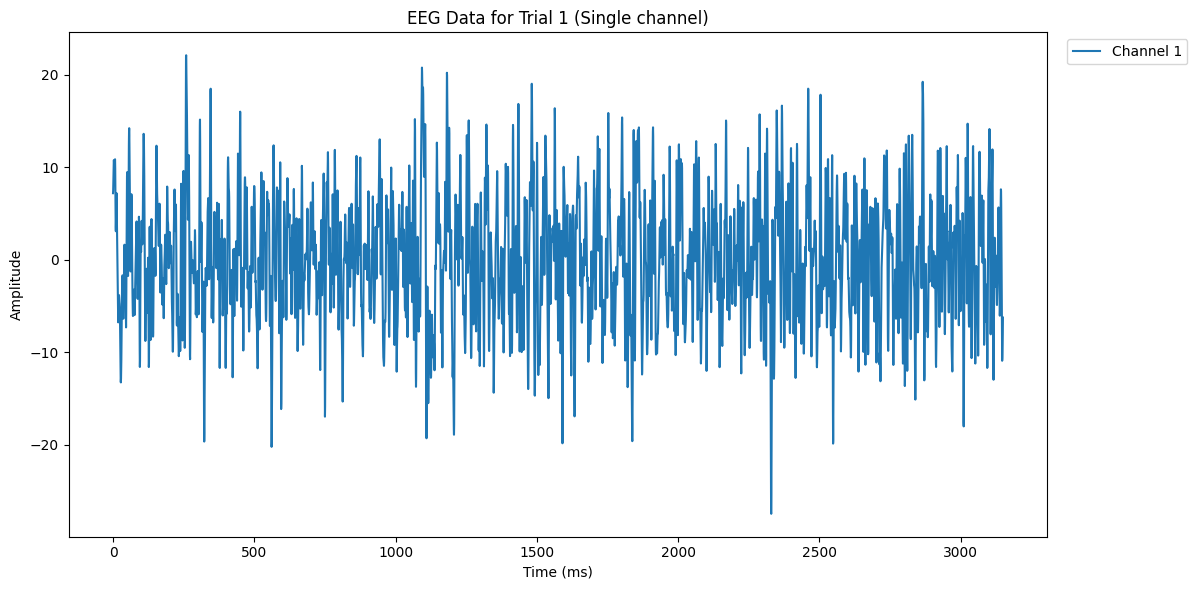

In [17]:
# load the associated label files
trainlabels_file = dataset_folder /"trainlabels.mat"

traindata_file = dataset_folder / "traintrials.mat"

file = h5py.File(traindata_file, "r")


with h5py.File(traindata_file, 'r') as f:
    v_data = f['v'][:]  # Load the dataset
    print(v_data.shape)



plt.figure(figsize=(12, 6))
#for ch in range(v_data.shape[0]):
x = np.arange(0, 3150, 1/1.8)
plt.plot(x[0:], v_data[0, :, 0], label=f'Channel 1')
plt.title('EEG Data for Trial 1 (Single channel)')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), ncol=1)
plt.tight_layout()
plt.show()